In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pickle

from src.gym import get_env
from src.models.actor import DoubleImageActor
from src.data.normalizer import StateActionNormalizer
from src.eval import rollout

from IPython.display import Image, display
import moviepy.editor as mpy

from ml_collections import ConfigDict

import cv2
import torch

import wandb

Importing module 'gym_38' (/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /data/scratch/ankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 2.0.1+cu117
Device count 2
/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /data/scratch/ankile/.cache as PyTorch extensions root...
Emitting ninja build file /data/scratch/ankile/.cache/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...
/data/scratch/ankile/sim-web-visualizer/sim_web_visualizer/__init__.py:15: UserWarning: No module named 'sapien'
  warnings.warn(str(e))
/data/scratch/ankile/sim-web-visualizer/sim_web_visualizer/__init__.py:16: UserWarning: 
No Sapien python library installed. Disable Sapien Visualizer.
 If you want to Sapien Visualizer, please consider install it via: pip3 install sapien
  warnings.warn(


In [3]:
api = wandb.Api()
run = api.run("/ankile/furniture-diffusion/runs/m5tjdd8b")
config = ConfigDict(run.config)

In [4]:
config.action_dim = config._fields["_fields"].action_dim
config.robot_state_dim = config._fields["_fields"].robot_state_dim

In [5]:
env = get_env(
    gpu_id=1,
    furniture="square_table",
    obs_type="image",
    num_envs=8,
    randomness="low",
    resize_img=True,
)

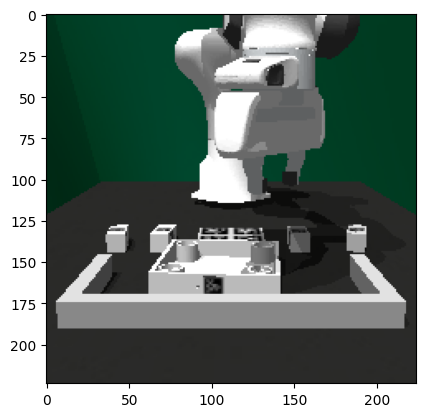

In [6]:
obs = env.reset()

plt.imshow(obs["color_image2"][0].cpu().numpy())

In [7]:
actor = DoubleImageActor(
    config=config,
    device="cuda:1",
    encoder_name="vip",
    freeze_encoder=True,
    normalizer=StateActionNormalizer(),
)

# Load state dict
actor.load_state_dict(torch.load("/data/scratch/ankile/furniture-diffusion/models/rare-bee-322/actor_best.pt"))

Total parameters: 3.96e+08
normalizer: 4.40e+01 parameters
encoder1: 2.56e+07 parameters
model: 3.70e+08 parameters


<All keys matched successfully>

In [8]:
rewards, imgs1, imgs2 = rollout(
    actor=actor,
    env=env,
    rollout_max_steps=1_000,
    pbar=True,
)

Eval OneLeg State Env:  44%|████▍     | 444/1000 [01:23<01:44,  5.31it/s]

square_table_top (id: 0), square_table_leg4 (id: 4) are assembled.
Assembled Set
[square_table_top (id: 0), square_table_leg4 (id: 4)] 


Eval OneLeg State Env:  51%|█████     | 510/1000 [01:35<01:25,  5.74it/s]

In [ ]:
# Check which rollouts were successful, if any
success_idx = torch.arange(len(rewards))[rewards.sum(dim=1) > 0]

success_idx

tensor([2])

In [ ]:
imgs1.shape, imgs2.shape, rewards.shape

(torch.Size([8, 1001, 224, 224, 3]),
 torch.Size([8, 1001, 224, 224, 3]),
 torch.Size([8, 1000]))

In [ ]:
imgs = torch.cat([imgs1.squeeze(0), imgs2.squeeze(0)], dim=3).cpu().numpy()

In [ ]:
imgs.shape

(8, 1001, 448, 224, 3)

# Stitch the videos together to make ready to view in the next cell


In [ ]:
# Display the annotated video as a gif
def display_gif(fn):
    return display(Image(data=fn, format="png"))


def make_gif(images, fname, fps=10):
    clip = mpy.ImageSequenceClip(images, fps=fps)
    clip.write_gif(fname, fps=fps)


make_gif(list(imgs[success_idx[0]]), "annotated_video.gif", fps=10)

display_gif("annotated_video.gif")